In [0]:
import math                      
import matplotlib.pyplot as plt  
import scipy                     
import cv2                       
import numpy as np               
import glob                      
import os                        
import pandas as pd              
import tensorflow as tf       
import itertools
import random
from random import shuffle       
from tqdm import tqdm            
from PIL import Image
from scipy import ndimage
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
%matplotlib inline
np.random.seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [0]:
train_dir = Path('/content/drive/My Drive/Colab Notebooks/Lab 2/3/10-monkey-species/training/training/')
test_dir = Path('/content/drive/My Drive/Colab Notebooks/Lab 2/3/10-monkey-species/validation/validation/')

In [5]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Lab 2/3/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [6]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [0]:
def image_show(num_image,label):
    for i in range(num_image):
        imgdir = Path('/content/drive/My Drive/Colab Notebooks/Lab 2/3/10-monkey-species/training/training/' + label)
        #print(imgdir)
        imgfile = random.choice(os.listdir(imgdir))
        #print(imgfile)
        img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Lab 2/3/10-monkey-species/training/training/'+ label +'/'+ imgfile)
       # print(img.shape)
        #print(label)
        plt.figure(i)
        plt.imshow(img)
        plt.title(imgfile)
    plt.show()

 pygmy_marmoset                


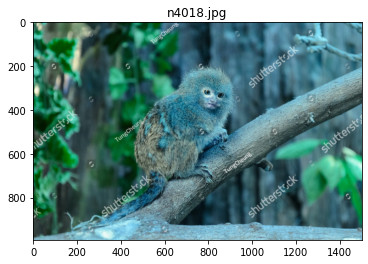

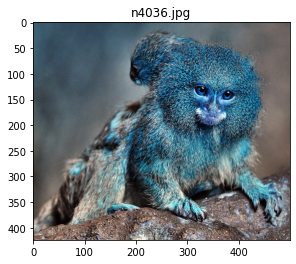

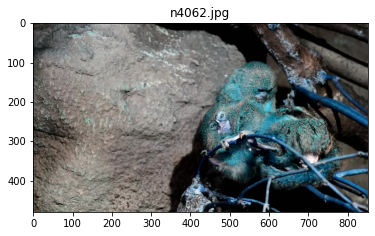

In [8]:
print(labels[4])
image_show(3,'n4')

In [9]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1107 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 64)       

In [0]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

Epoch 1/100
17/17 [==============================] - 42s 2s/step - loss: 2.2830 - acc: 0.1429 - val_loss: 2.0929 - val_acc: 0.3047

Epoch 00001: val_acc improved from -inf to 0.30469, saving model to /content/model.h5f
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.9952 - acc: 0.2730 - val_loss: 1.7458 - val_acc: 0.3516

Epoch 00002: val_acc improved from 0.30469 to 0.35156, saving model to /content/model.h5f
Epoch 3/100
17/17 [==============================] - 27s 2s/step - loss: 1.8108 - acc: 0.3216 - val_loss: 1.7372 - val_acc: 0.4180

Epoch 00003: val_acc improved from 0.35156 to 0.41797, saving model to /content/model.h5f
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 1.6855 - acc: 0.3787 - val_loss: 1.7141 - val_acc: 0.4062

Epoch 00004: val_acc did not improve from 0.41797
Epoch 5/100
17/17 [==============================] - 36s 2s/step - loss: 1.6174 - acc: 0.3980 - val_loss: 1.4788 - val_acc: 0.4455

Epoch 00005: val_acc im

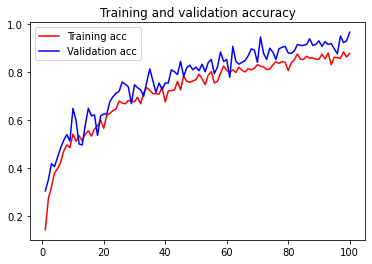

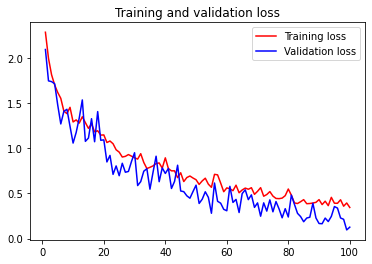

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [17]:
print(metrics.classification_report(validation_generator.classes, Y_pred_classes,target_names=labels))

                                 precision    recall  f1-score   support

 mantled_howler                       0.75      0.46      0.57        26
 patas_monkey                         0.64      0.82      0.72        28
 bald_uakari                          0.93      0.93      0.93        27
 japanese_macaque                     0.87      0.87      0.87        30
 pygmy_marmoset                       0.90      0.69      0.78        26
 white_headed_capuchin                0.95      0.68      0.79        28
 silvery_marmoset                     1.00      0.65      0.79        26
 common_squirrel_monkey               0.85      0.61      0.71        28
 black_headed_night_monkey            0.64      0.93      0.76        27
 nilgiri_langur                       0.47      0.85      0.60        26

                       accuracy                           0.75       272
                      macro avg       0.80      0.75      0.75       272
                   weighted avg       0.80      0